# Deep Learning
## Assignment 4
Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify notMNIST characters.

The goal of this assignment is make the neural network convolutional.

### Note for GPU on Mac
Set the following in your shell to prevent 'out of memory' errors from TensorFlow, prior to running jupyter notebook:

`export CUDA_VISIBLE_DEVICES=1`

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

from matplotlib.pyplot import specgram
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:

- convolutions need the image data formatted as a cube (`Width by Height by #Channels`)
- labels as float 1-hot encodings.

In [3]:
IM_SIZE = image_size = 28
L = NUM_LABELS = 10
C = NUM_CHANNELS = 1 # grayscale = C

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, IM_SIZE, IM_SIZE, NUM_CHANNELS)).astype(np.float32)   # [-1, 28, 28, C]
  labels = (np.arange(NUM_LABELS) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels   = reformat(test_dataset, test_labels)

print('Training set',   train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set',       test_dataset.shape,  test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def get_accuracy(predictions, labels):
  """ Define our accuracy measure. Return accuracy % """
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [19]:
BATCH_SIZE = 20
PATCH_SIZE = K = 3    # Kernel size
DEPTH = D = 16        # D


# 3 conv layers with their channel counts, and a 
# last Fully Connected layer (that last fc layer has 10 softmax nodes)
P = 4  # 1st hidden layer
Q = 8  # 2nd hidden
R = 16  # 3rd hidden
S = 64  # Last Fully Connected layer

L = NUM_LABELS # Output labels  

graph = tf.Graph()
with graph.as_default():
    # Input data: images: Batch size x Width x Height x Channels
    X = tf.placeholder(tf.float32, [None,IM_SIZE,IM_SIZE,C]) # Batch size x 28 x 28 x Channels
    # Correct labels here: [Batch size, Num Labels]
    Y_ = tf.placeholder(tf.float32, [None, L]) 
    # learning rate
    lr = tf.placeholder(tf.float32, name='lr')
    # pkeep = % of probs to keep  (0.5 to 1.0)
    pkeep = tf.placeholder(tf.float32, name='pkeep')
    
    ## Weights 
    # W1:  5x5 Kernel, C (=1) input channel, P output channels
    W1 = tf.Variable(tf.truncated_normal([K,K,C,P], stddev=0.1))
    B1 = tf.Variable(tf.ones([P])/10)
    
    W2 = tf.Variable(tf.truncated_normal([K,K,P,Q], stddev=0.1))
    B2 = tf.Variable(tf.ones([Q])/10)
    
    W3 = tf.Variable(tf.truncated_normal([K,K,Q,R], stddev=0.1))
    B3 = tf.Variable(tf.ones([R])/10)
    

    ## Model calculations - 1
    # XX = tf.reshape(X, [-1, I*I])   # flatten into 784 = Image Size (28) x Image Size (28)
    
    s1 = 1  # stride is 1;  output 28x28
    Y1 = tf.nn.relu(tf.nn.conv2d(X,  W1, strides=[1,s1,s1,1], padding='SAME') + B1)
    s2 = 2  # stride is 2; output 14x14
    Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1,s2,s2,1], padding='SAME') + B2)
    s3 = 2  # stride is 2; output 7x7
    Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1,s3,s3,1], padding='SAME') + B3)
    
    # reshape the output from Y3 to fully connected layer; should be 7x7xR
    ''' Note that dim of image is reduced by strides (s1,s2,s3) after the conv layers
        Therefore, the dim of image to fc layer is [IM_SIZE//(s1*s2*s3), IM_SIZE//(s1*s2*s3)]
    '''
    fc1_in_dim = IM_SIZE//(s1*s2*s3) * IM_SIZE//(s1*s2*s3)   # should be 7*7
    YY = tf.reshape(Y3, shape=[-1, fc1_in_dim * R])          # 7*7*R
    
    # for fully connected (FC) RELU layer , depth=S
    W4 = tf.Variable(tf.truncated_normal([fc1_in_dim * R,S], stddev=0.1))  # should be [7*7*R, S]
    B4 = tf.Variable(tf.ones([S])/10)
    # last FC Softmax layer, depth=L(=10)
    W5 = tf.Variable(tf.truncated_normal([S, L], stddev=0.1))  # last 
    B5 = tf.Variable(tf.ones([L])/10)  # L = num_labels
    
    Y4  = tf.nn.relu(tf.matmul(YY, W4) + B4)
    Y4d = tf.nn.dropout(Y4, pkeep)   # Dropout
    
    # Outputs... get logits, then softmax on it
    Ylogits = tf.matmul(Y4d, W5) + B5
    Y = tf.nn.softmax(Ylogits)
    
    # Loss Function cross-entropy (= -sum(Y_i * log(Yi)) ), normalised for batches of BATCH_SIZE images
    # TensorFlow provides the softmax_cross_entropy_with_logits function to avoid numerical stability
    # problems with log(0) which is NaN
    
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(Ylogits, Y_)
    cross_entropy = tf.reduce_mean(cross_entropy)*BATCH_SIZE
    
    # accuracy of the trained model, between 0 (worst) and 1 (best)
    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # training step, the learning rate is a placeholder
    train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)
    
    ## Init the session
    init = tf.initialize_all_variables()
    

In [20]:
# Inititalize...
session = tf.Session(graph=graph)

session.run(init)
print("Initialized")


Initialized


In [21]:
# For storing results - for charting

steps_train = []   # X1 
train_losses = []
train_acc = []

steps_test = []    # X2
valid_acc = []
test_acc  = []
valid_losses = []
test_losses  = []

# Define a Training Step func to run the model
def training_step(step, update_train_data, update_test_data):
    """ Invoke this function in a loop: Runs one training step 
        Runs one training step and outputs stats on Train or Test data periodically
        
        step: iteration number
        update_test_data:  Bool to indicate when to update Test stats for output
        update_train_data: Bool to indicate when to update Train stats for output
    """

    # learning rate decay
    max_learning_rate = 0.003
    min_learning_rate = 0.0001
    decay_rate = 2000.0
    learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * np.exp(-step/decay_rate)
    
    offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
    #print ('offset: ', offset)
    batch_X = train_dataset[offset:(offset + BATCH_SIZE), :, :, :]
    batch_Y = train_labels [offset:(offset + BATCH_SIZE), :]
    train_dict = {X: batch_X, 
                  Y_: batch_Y, 
                 lr: learning_rate, 
                 pkeep: 0.75}  # some dropout
    
    
    # Run one Training step
    acc_tr, los_tr, _ = session.run([accuracy, cross_entropy, train_step], feed_dict=train_dict)
    # Store the results for charting
    steps_train.append(step)     # x1
    train_acc.append(acc_tr)     # y1
    train_losses.append(los_tr)  # z1
    
    # Success? print Training set results
    if update_train_data:
        # acc_tr, los_tr = session.run([accuracy, cross_entropy], feed_dict=train_dict)
        print (str(step) + ":\ttrain accu:\t" + str(acc_tr) + "\tloss:" + str(los_tr) + 
              "\t(lr:" + str(learning_rate) + ")")

        
    # print Validation and Test results
    if update_test_data:
        valid_dict = {X: valid_dataset, 
                      Y_: valid_labels, 
                     lr: learning_rate, 
                     pkeep: 1.0}  # no dropout
        acc_va, los_va = session.run([accuracy, cross_entropy], feed_dict=valid_dict)
        print (str(step) + ":\tvalid. accu:\t" + str(acc_va) + "\tloss:" + str(los_va) + 
              "\t(lr:" + str(learning_rate) + ")")
        
        
        test_dict = {X: test_dataset, 
                     Y_: test_labels,
                    lr: learning_rate,
                    pkeep: 1.0}  # no dropout
        acc_ts, los_ts = session.run([accuracy, cross_entropy], feed_dict=test_dict)
        print (str(step) + ":\t*** test accu:\t" + str(acc_ts) + "\tloss:" + str(los_ts) + 
              "\t(lr:" + str(learning_rate) + ")")
        
        # Store results for charting
        steps_test.append(step)    # x2
        valid_acc.append(acc_va)   # y2
        test_acc.append (acc_ts)   # y3
        valid_losses.append(los_va) # z2
        test_losses.append (los_ts) # z3
        
    # Run one training step
    # session.run(train_step, feed_dict=train_dict)
    


In [22]:
## Run the model
NUM_STEPS = 5000

for i in range(NUM_STEPS+1):
    training_step(i, i % 200 == 0, i % 200 == 0)

0:	train accu:	0.05	loss:46.8859	(lr:0.003)
0:	valid. accu:	0.0995	loss:46.104	(lr:0.003)
0:	*** test accu:	0.0991	loss:46.0704	(lr:0.003)
200:	train accu:	0.75	loss:16.0546	(lr:0.0027240285123)
200:	valid. accu:	0.801	loss:13.4466	(lr:0.0027240285123)
200:	*** test accu:	0.8703	loss:8.80365	(lr:0.0027240285123)
400:	train accu:	0.85	loss:14.0523	(lr:0.00247431918393)
400:	valid. accu:	0.8206	loss:11.9631	(lr:0.00247431918393)
400:	*** test accu:	0.8903	loss:7.46272	(lr:0.00247431918393)
600:	train accu:	0.95	loss:7.036	(lr:0.00224837283998)
600:	valid. accu:	0.8369	loss:10.8212	(lr:0.00224837283998)
600:	*** test accu:	0.9065	loss:6.31109	(lr:0.00224837283998)
800:	train accu:	0.95	loss:8.63739	(lr:0.0020439281335)
800:	valid. accu:	0.8427	loss:10.3205	(lr:0.0020439281335)
800:	*** test accu:	0.9115	loss:6.06421	(lr:0.0020439281335)
1000:	train accu:	0.85	loss:8.75011	(lr:0.00185893891317)
1000:	valid. accu:	0.851	loss:9.79976	(lr:0.00185893891317)
1000:	*** test accu:	0.9169	loss:5.7

### Results: Test acc: 94.47%  pkeep = 0.5, STEPS=5000, 
```4950:	accuracy:	0.875	loss:5.69609	(lr:0.000344072671746)
5000:	accuracy:	0.75	loss:15.1087	(lr:0.000338046496009)
5000:	valid. acc:	0.8818	loss:6.09631	(lr:0.000338046496009)
5000:	*** test acc:	0.9447	loss:3.00196	(lr:0.000338046496009)
```

### Results: Test acc: 94.63% pkeep = 0.75, STEPS=3000
```
2950:	train accu:	0.9375	loss:5.9666	(lr:0.000763458308431)
3000:	train accu:	0.875	loss:19.2072	(lr:0.00074707746443)
3000:	valid. accu:	0.8849	loss:5.97304	(lr:0.00074707746443)
3000:	*** test accu:	0.9463	loss:2.84099	(lr:0.00074707746443)
```

### Results: Kernel: 3x3, Batch: 20, 
pkeep = 0.75, Steps = 3000, P=4, Q=8, R=16, S=64
```
3000:	train accu:	0.9	loss:7.78198	(lr:0.00074707746443)
3000:	valid. accu:	0.8723	loss:8.31262	(lr:0.00074707746443)
3000:	*** test accu:	0.9382	loss:4.47826	(lr:0.00074707746443)
```

```
6000:	train accu:	0.95	loss:3.58783	(lr:0.000244382498267)
6000:	valid. accu:	0.8881	loss:7.35652	(lr:0.000244382498267)
6000:	*** test accu:	0.948	loss:3.50985	(lr:0.000244382498267)
```

In [24]:
print(len(steps_test), len(test_acc), len(valid_acc), len(valid_losses))
print(len(steps_train), len(train_acc), len(train_losses))


26 26 26 26
5001 5001 5001


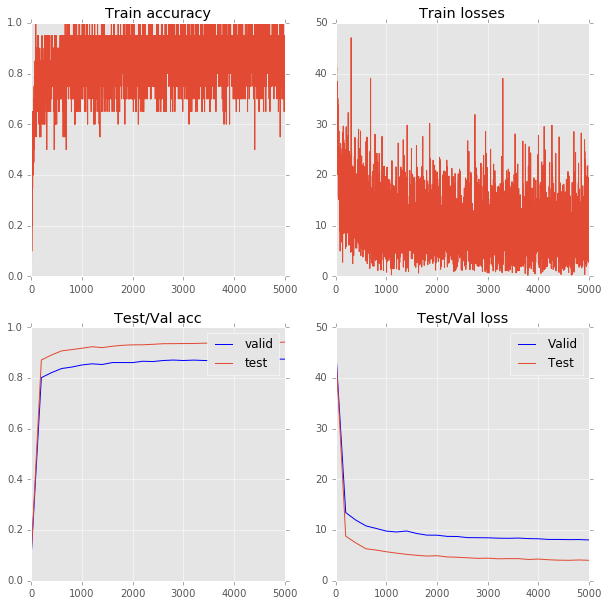

In [33]:

# Plot
plt.figure(1, figsize=(10,10))

plt.subplot(221)
plt.plot(steps_train, train_acc)
plt.title('Train accuracy')

plt.subplot(222)
plt.plot(steps_train, train_losses)
plt.title('Train losses')

plt.subplot(223)
plt.plot(steps_test, valid_acc, 'b', label='valid')
plt.plot(steps_test, test_acc, label='test')
plt.title('Test/Val acc')
plt.legend()

plt.subplot(224)
plt.plot(steps_test, valid_losses, 'b', label='Valid')
plt.plot(steps_test, test_losses, label='Test')
plt.title('Test/Val loss')
plt.legend()

plt.show()


### Results:  Test Accuracy 94.11%
```
# 3 conv layers with their channel counts, and a 
# last Fully Connected layer (that last fc layer has 10 softmax nodes)
P = 4  # 1st hidden layer
Q = 8  # 2nd hidden
R = 16  # 3rd hidden
S = 64  # Last Fully Connected layer
=====

5000:	train accu:	0.7	loss:21.9006	(lr:0.000338046496009)
5000:	valid. accu:	0.8739	loss:8.05157	(lr:0.000338046496009)
5000:	*** test accu:	0.9411	loss:4.03993	(lr:0.000338046496009)
```